In [35]:
# import torch
import pandas as pd

pd.set_option("display.max_columns", None)
import numpy as np
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler, QuantileTransformer, OrdinalEncoder, LabelEncoder, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline

# Statistics
import scipy.stats as stats
import optuna # used for finding good hyperparameters for a model
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [2]:
df_train_org = pd.read_csv("./train.csv", index_col="id")
df_test_org = pd.read_csv("./test.csv", index_col="id")

print("Train shape: ", df_train_org.shape)
print("Test shape: ", df_test_org.shape)


Train shape:  (1235, 28)
Test shape:  (824, 27)


In [3]:
df_train_org.head()


,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,more_3_sec,depressed,absent,slight,slight,less_1_liter,6.5,decreased,distend_small,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,more_3_sec,mild_pain,absent,moderate,none,more_1_liter,2.0,absent,distend_small,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,less_3_sec,extreme_pain,hypomotile,moderate,slight,none,3.5,NaN,distend_large,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,more_3_sec,mild_pain,hypomotile,moderate,slight,more_1_liter,2.0,decreased,distend_small,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,less_3_sec,alert,hypomotile,none,slight,less_1_liter,7.0,normal,normal,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived


In [4]:
df_train_org.isna().sum().sort_values()

surgery                    0
lesion_3                   0
lesion_2                   0
lesion_1                   0
surgical_lesion            0
abdomo_protein             0
total_protein              0
packed_cell_volume         0
nasogastric_reflux_ph      0
cp_data                    0
outcome                    0
age                        0
hospital_number            0
rectal_temp                0
pulse                      0
respiratory_rate           0
capillary_refill_time      6
peristalsis               20
nasogastric_reflux        21
mucous_membrane           21
abdominal_distention      23
temp_of_extremities       39
pain                      44
abdomo_appearance         48
peripheral_pulse          60
nasogastric_tube          80
rectal_exam_feces        190
abdomen                  213
dtype: int64

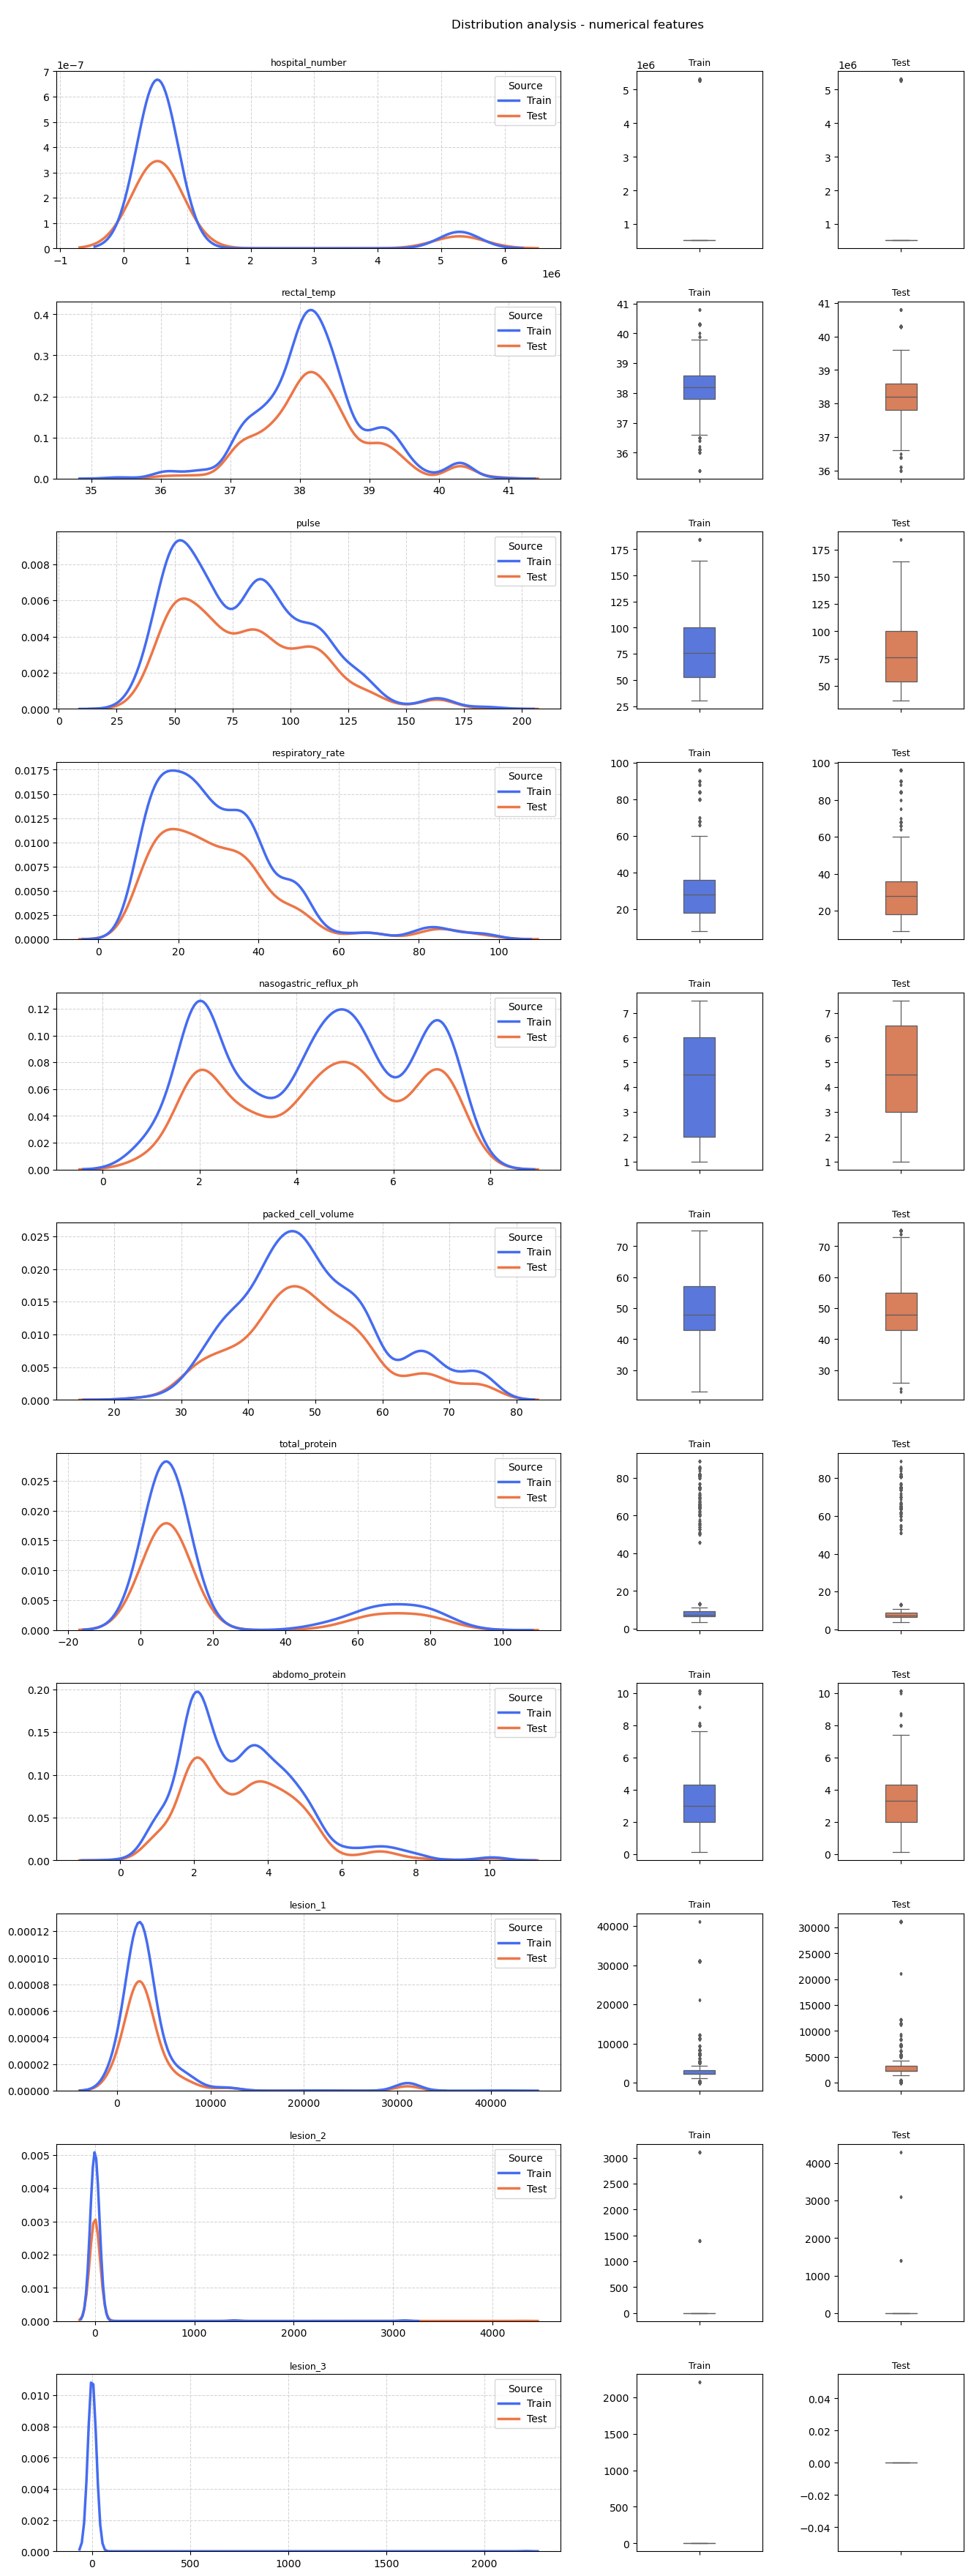

In [6]:
num = df_train_org.select_dtypes(include=["int64", "float64"]).columns

df = pd.concat(
    [df_train_org[num].assign(Source="Train"), df_test_org[num].assign(Source="Test")],
    ignore_index=True,
)

fig, axes = plt.subplots(
    len(num),
    3,
    figsize=(16, len(num) * 4),
    gridspec_kw={"wspace": 0.3, "hspace": 0.3, "width_ratios": [0.8, 0.2, 0.2]},
)

for i, col in enumerate(num):
    ax = axes[i, 0]
    sns.kdeplot(
        data=df[[col, "Source"]],
        x=col,
        hue="Source",
        palette=["#456cf0", "#ed7647"],
        linewidth=2.5,
        warn_singular=False,
        ax=ax,
    )
    ax.set_title(f"\n{col}", fontsize=9)
    ax.grid(
        visible=True, which="both", linestyle="--", color="lightgrey", linewidth=0.75
    )
    ax.set(xlabel="", ylabel="")

    ax = axes[i, 1]
    sns.boxplot(
        data=df.loc[df.Source == "Train", [col]],
        y=col,
        width=0.25,
        linewidth=0.90,
        fliersize=2.25,
        color="#456cf0",
        ax=ax,
    )
    ax.set(xlabel="", ylabel="")
    ax.set_title("Train", fontsize=9)

    ax = axes[i, 2]
    sns.boxplot(
        data=df.loc[df.Source == "Test", [col]],
        y=col,
        width=0.25,
        linewidth=0.90,
        fliersize=2.25,
        color="#ed7647",
        ax=ax,
    )
    ax.set(xlabel="", ylabel="")
    ax.set_title("Test", fontsize=9)

plt.suptitle(
    f"\nDistribution analysis - numerical features\n",
    fontsize=12,
    y=0.9,
    x=0.57,
)
plt.show()

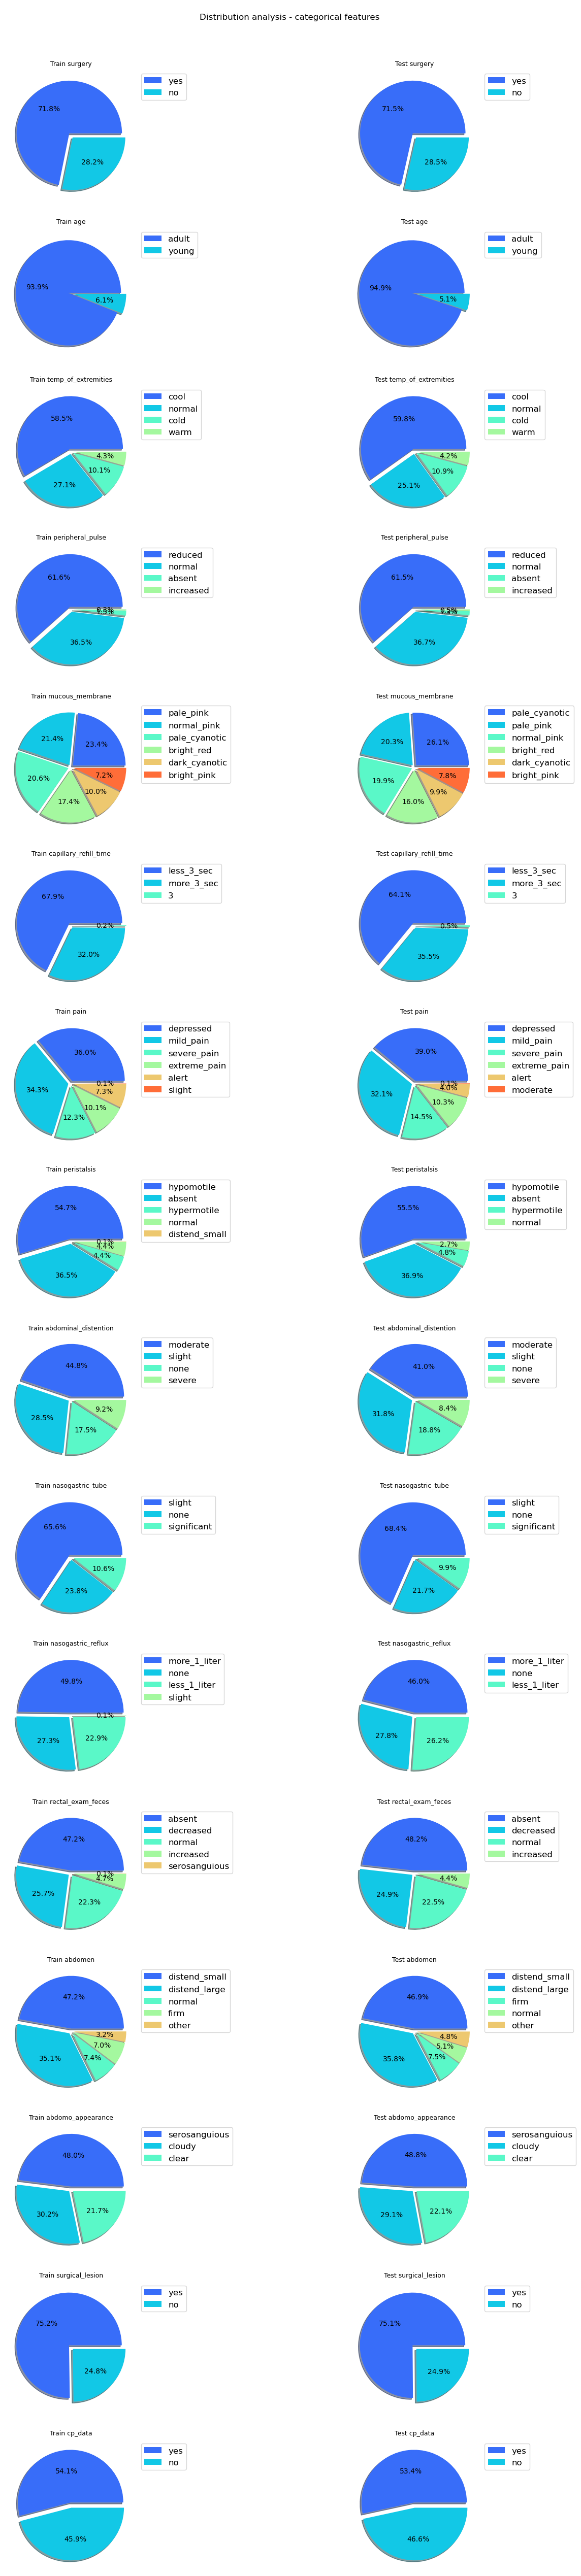

In [13]:
sns.set_palette("rainbow")

num = df_train_org.drop(columns="outcome").select_dtypes(include=["object"]).columns

df = pd.concat(
    [df_train_org[num].assign(Source="Train"), df_test_org[num].assign(Source="Test")],
    axis=0,
    ignore_index=True,
)
fig, axes = plt.subplots(len(num), 2, figsize=(16, len(num) * 4))

for i, col in enumerate(num):
    train_dist = df.loc[df.Source == "Train", [col]].value_counts()
    test_dist = df.loc[df.Source == "Test", [col]].value_counts()

    ax = axes[i, 0]
    ax.pie(train_dist, shadow=True, explode=[0.05] * len(train_dist), autopct="%.1f%%")
    ax.legend(
        [category[0] for category in train_dist.index],
        loc="upper left",
        bbox_to_anchor=(1, 1),
        fontsize=12,
    )
    ax.set(xlabel="", ylabel="")
    ax.set_title(f"Train {col}", fontsize=9)

    ax = axes[i, 1]
    ax.pie(test_dist, shadow=True, explode=[0.05] * len(test_dist), autopct="%.1f%%")
    ax.legend(
        [category[0] for category in test_dist.index],
        loc="upper left",
        bbox_to_anchor=(1, 1),
        fontsize=12,
    )
    ax.set(xlabel="", ylabel="")
    ax.set_title(f"Test {col}", fontsize=9)

plt.suptitle(
    f"\nDistribution analysis - categorical features\n",
    fontsize=12,
    y=0.9,
    x=0.57,
)
plt.show()

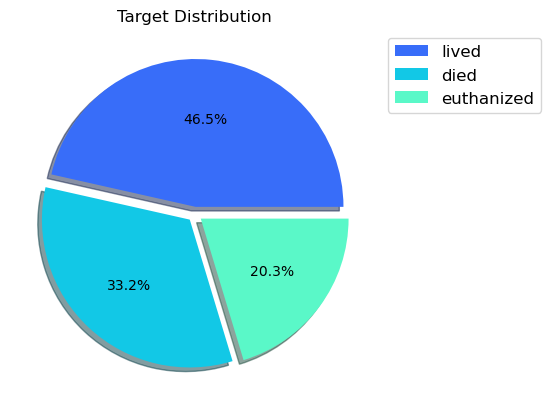

<Figure size 500x1000 with 0 Axes>

In [16]:
target_dist = df_train_org["outcome"].value_counts()
plt.pie(target_dist, shadow=True, explode=[0.05, 0.05, 0.05], autopct="%.1f%%")

plt.title("Target Distribution", fontsize=12)
plt.legend(target_dist.index, loc="upper left", bbox_to_anchor=(1, 1), fontsize=12)
plt.figure(figsize=(5, 10))
plt.show()

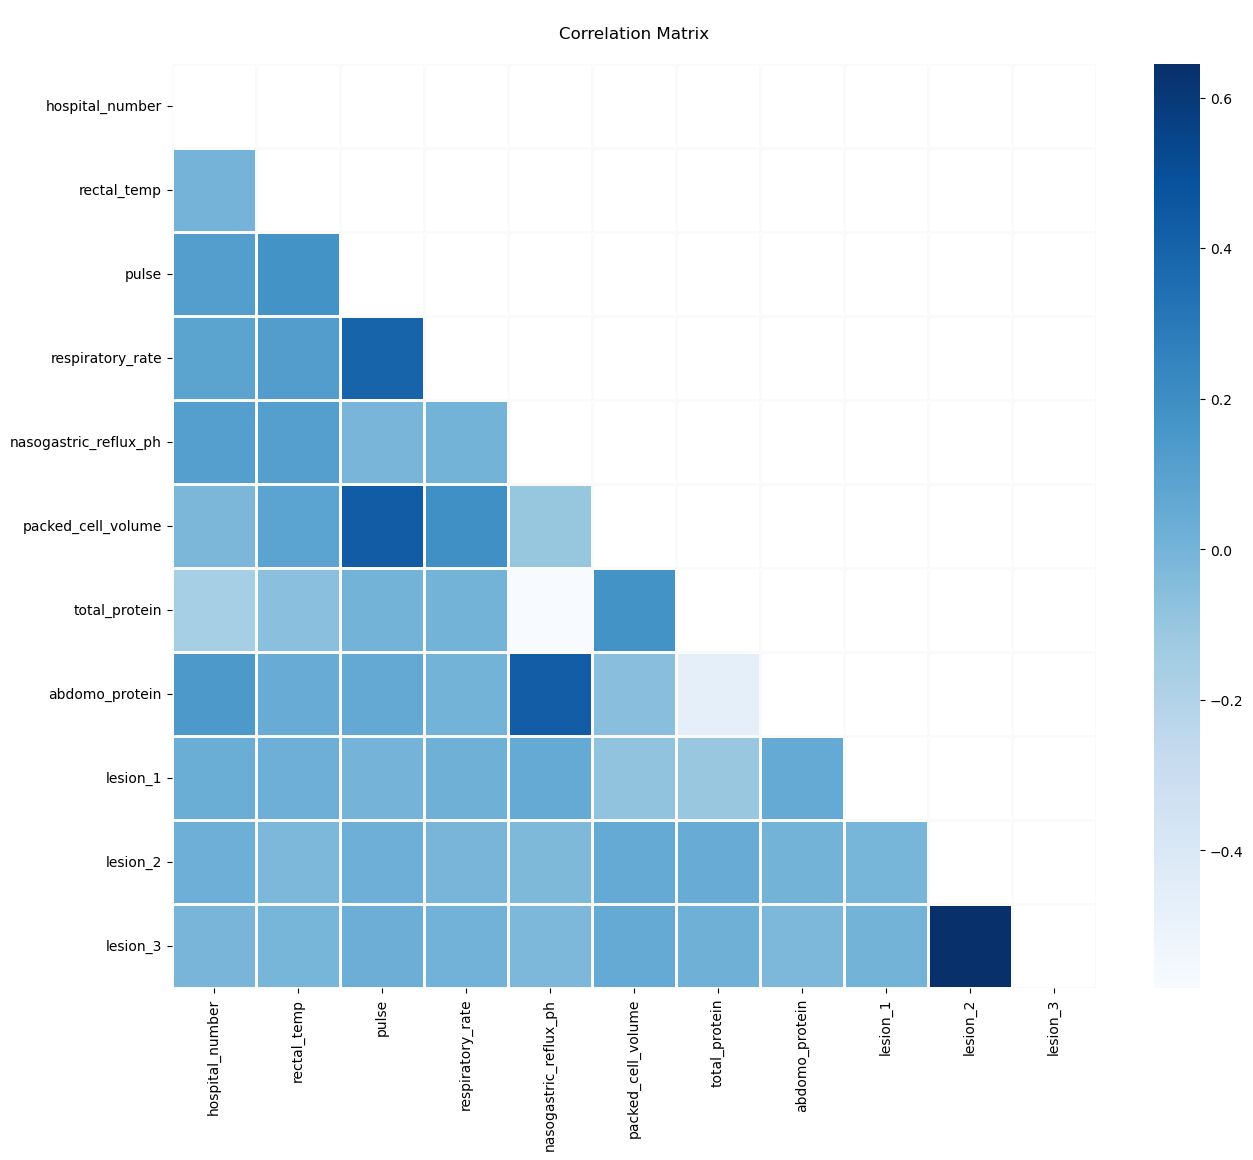

In [19]:
corr_matrix = df_train_org.select_dtypes(include=np.number).corr()

mask = np.triu(corr_matrix)


plt.figure(figsize=(15, 12))

sns.heatmap(
    data=corr_matrix,
    mask=mask,
    cmap="Blues",
    linewidths=1,
    square=True,
    linecolor="#fafafa",
)
plt.title("\nCorrelation Matrix\n", fontsize=12)
plt.show()

In [21]:
categorical_cols = df_train_org.select_dtypes(include=np.number).columns

threshold = 0.05


for col in categorical_cols:
    contingency_table = pd.crosstab(df_train_org[col], df_train_org["outcome"])

    chi2, p, _, _ = stats.chi2_contingency(contingency_table)

    print(
        f"{col:<25} |  ",
        "\033[32mPassed" if p < threshold else "\033[31mFailed",
        "\033[0m",
    )

hospital_number           |   Passed 
rectal_temp               |   Passed 
pulse                     |   Passed 
respiratory_rate          |   Passed 
nasogastric_reflux_ph     |   Passed 
packed_cell_volume        |   Passed 
total_protein             |   Passed 
abdomo_protein            |   Passed 
lesion_1                  |   Passed 
lesion_2                  |   Passed 
lesion_3                  |   Failed 


In [22]:
df_train_org.drop("lesion_3", axis=1, inplace=True)

In [24]:
X_train = df_train_org.drop(columns="outcome")
Y_train = df_train_org[["outcome"]]

In [25]:
numeric_pipeline = make_pipeline(
    # SimpleImputer(strategy='mean'),
    QuantileTransformer(output_distribution="normal", random_state=42),
    StandardScaler(),
)

categorical_pipeline = make_pipeline(
    OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=10)
)

In [26]:
transformer = make_column_transformer(
    (numeric_pipeline, make_column_selector(dtype_include=np.number)),
    (categorical_pipeline, make_column_selector(dtype_include=object)),
    remainder="passthrough",
    verbose_feature_names_out=False,
)

transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('quantiletransformer',
                                                  QuantileTransformer(output_distribution='normal',
                                                                      random_state=42)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x00000282358AEDC0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=10))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x00000282358AEB20>)],
                  verbose_feature_names_out=False)

In [30]:
target_encoder = OrdinalEncoder(categories=[["died", "euthanized", "lived"]])

In [31]:
X_train = transformer.fit_transform(X_train)
Y_train = target_encoder.fit_transform(Y_train).ravel()

In [32]:
X_train = pd.DataFrame(X_train, columns=transformer.get_feature_names_out(), index=df_train_org.index)
X_train.head()

,hospital_number,rectal_temp,pulse,respiratory_rate,nasogastric_reflux_ph,packed_cell_volume,total_protein,abdomo_protein,lesion_1,lesion_2,surgery,age,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,rectal_exam_feces,abdomen,abdomo_appearance,surgical_lesion,cp_data
id,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.105878,-0.109224,1.700853,-0.187200,0.602077,0.558758,0.532677,0.118752,0.204884,-0.080093,1.0,0.0,1.0,3.0,2.0,2.0,1.0,0.0,3.0,2.0,0.0,1.0,1.0,2.0,1.0,0.0
1,0.492654,-0.950993,0.350477,-1.401771,-0.658106,-1.490259,0.920788,-0.774723,0.048081,-0.080093,1.0,0.0,1.0,2.0,4.0,2.0,3.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,1.0,0.0
2,0.040881,0.252304,1.294186,0.031250,-0.196908,-1.022449,-0.940529,0.118752,0.785507,-0.080093,1.0,0.0,1.0,3.0,5.0,1.0,2.0,3.0,0.0,2.0,2.0,NaN,0.0,2.0,1.0,0.0
3,1.318004,-1.563261,-0.081099,0.163864,-0.658106,0.292826,-0.400509,0.463496,0.048081,-0.080093,1.0,0.0,0.0,3.0,5.0,2.0,3.0,3.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0
4,2.417133,-0.336523,-0.782074,1.073563,0.936927,-0.189014,-0.175523,-0.231932,-3.004247,-0.080093,0.0,0.0,2.0,2.0,3.0,1.0,0.0,3.0,1.0,2.0,0.0,3.0,3.0,1.0,0.0,1.0


In [33]:
X_train.describe()

,hospital_number,rectal_temp,pulse,respiratory_rate,nasogastric_reflux_ph,packed_cell_volume,total_protein,abdomo_protein,lesion_1,lesion_2,surgery,age,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,rectal_exam_feces,abdomen,abdomo_appearance,surgical_lesion,cp_data
count,1.235000e+03,1.235000e+03,1.235000e+03,1.235000e+03,1.235000e+03,1.235000e+03,1.235000e+03,1.235000e+03,1.235000e+03,1.235000e+03,1235.000000,1235.000000,1196.000000,1175.000000,1214.000000,1229.000000,1191.000000,1215.000000,1212.000000,1155.000000,1214.000000,1045.000000,1022.000000,1187.000000,1235.000000,1235.000000
mean,-1.726015e-17,2.013684e-17,-2.589022e-17,-8.630074e-18,-8.630074e-18,4.315037e-18,1.654097e-17,2.157518e-18,-5.753382e-18,4.458871e-16,0.718219,0.060729,1.255017,2.582128,3.009061,1.318145,2.083963,1.902058,1.214521,1.418182,1.045305,1.023923,0.964775,1.262848,0.752227,0.540891
std,1.000405e+00,1.000405e+00,1.000405e+00,1.000405e+00,1.000405e+00,1.000405e+00,1.000405e+00,1.000405e+00,1.000405e+00,1.000405e+00,0.450050,0.238929,0.691381,0.585038,1.609663,0.469428,1.219451,1.475038,1.279394,0.848599,0.709439,1.191606,1.004755,0.793094,0.431894,0.498527
min,-5.050505e+00,-5.051426e+00,-5.020929e+00,-4.840693e+00,-3.596834e+00,-4.150241e+00,-5.034929e+00,-5.083975e+00,-3.004247e+00,-8.009297e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-6.546484e-01,-6.050247e-01,-6.981833e-01,-6.315291e-01,-6.581064e-01,-5.607593e-01,-6.421395e-01,-7.747232e-01,-2.051666e-01,-8.009297e-02,0.000000,0.000000,1.000000,2.000000,2.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000
50%,3.254254e-03,7.159243e-02,-9.607834e-03,3.124956e-02,2.686444e-02,-6.902327e-02,1.362882e-02,-3.330905e-02,2.048838e-01,-8.009297e-02,1.000000,0.000000,1.000000,3.000000,3.000000,1.000000,2.000000,3.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,6.550365e-01,7.175869e-01,6.836918e-01,4.815389e-01,5.060942e-01,5.587579e-01,6.469165e-01,6.512488e-01,5.254878e-01,-8.009297e-02,1.000000,0.000000,2.000000,3.000000,4.000000,2.000000,3.000000,3.000000,3.000000,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000
max,5.057013e+00,5.057896e+00,5.011396e+00,4.800778e+00,3.691014e+00,4.029959e+00,5.030611e+00,5.051598e+00,3.311785e+00,1.500267e+01,1.000000,1.000000,3.000000,3.000000,5.000000,2.000000,5.000000,4.000000,3.000000,2.000000,3.000000,4.000000,4.000000,2.000000,1.000000,1.000000


In [34]:
X_train_optuna, X_val_optuna, Y_train_optuna, Y_val_optuna = train_test_split(X_train, Y_train, train_size=0.9)

In [45]:
from functools import partial


def objective(trial, model_="xgb"):
    if model_ == "xgb":
        model = XGBClassifier(
            eta=trial.suggest_float("eta", 0.001, 0.3),
            n_estimators=trial.suggest_int("n_estimators", 32, 1024),
            max_depth=trial.suggest_int("max_depth", 1, 10),
            reg_lambda=trial.suggest_float("reg_lambda", 0.01, 10),
            subsample=trial.suggest_float("subsample", 0.01, 1),
            min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
            colsample_bytree=trial.suggest_float("colsample_bytree", 0.01, 1),
            objective=trial.suggest_categorical("objective", ["multi:softmax"]),
        )
    elif model_ == "lgbm":
        model = LGBMClassifier(
            n_estimators=trial.suggest_int("n_estimators", 32, 1024),
            learning_rate=trial.suggest_float("learning_rate", 0.001, 0.5),
            max_depth=trial.suggest_int("max_depth", 1, 10),
            num_leaves=trial.suggest_int("num_leaves", 2, 1024),
            reg_lambda=trial.suggest_float("reg_lambda", 0.001, 10),
            reg_alpha=trial.suggest_float("reg_alpha", 0, 10),
            subsample=trial.suggest_float("subsample", 0.001, 1),
            colsample_bytree=trial.suggest_float("colsample_bytree", 0.5, 1),
            min_child_samples=trial.suggest_int("min_child_samples", 2, 1024),
            min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
            objective=trial.suggest_categorical("objective", ["multiclass"]),
            metric=trial.suggest_categorical("metric", ["multi_logloss"]),
            boosting_type=trial.suggest_categorical("boosting_type", ["gbdt"]),
        )
    elif model_ == "catboost":
        model = CatBoostClassifier(
            iterations=trial.suggest_int("iterations", 32, 1024),
            learning_rate=trial.suggest_float("learning_rate", 0.001, 0.3),
            depth=trial.suggest_int("depth", 1, 10),
            l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 0.01, 10),
            grow_policy=trial.suggest_categorical("grow_policy", ["Depthwise"]),
            bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
            od_type=trial.suggest_categorical("od_type", ["Iter"]),
            eval_metric=trial.suggest_categorical("eval_metric", ["TotalF1"]),
            loss_function=trial.suggest_categorical("loss_function", ["MultiClass"]),
            random_state=trial.suggest_categorical("random_state", [42]),
            verbose=trial.suggest_categorical("verbose", [0]),
        )

    model.fit(
        X_train_optuna,
        Y_train_optuna,
        eval_set=[(X_train_optuna, Y_train_optuna), (X_val_optuna, Y_val_optuna)],
        verbose=False,
    )
    return f1_score(Y_val_optuna, model.predict(X_val_optuna), average="micro")

best_hyperparams_map = {}
for mod in ["xgb", "lgbm", "catboost"]:
    objective_func = partial(objective, model_=mod)

    study = optuna.create_study(direction="maximize")
    study.optimize(objective_func, n_trials=50)

    best_hyperparams = study.best_params

    best_hyperparams_map[f"best_hyperparams_{mod}"] = best_hyperparams
    
print(best_hyperparams_map)

[I 2023-10-13 17:11:35,457] A new study created in memory with name: no-name-17b41612-3a51-445a-813e-8962dfca3b84


[I 2023-10-13 17:11:37,789] Trial 0 finished with value: 0.7419354838709677 and parameters: {'eta': 0.13054759429597576, 'n_estimators': 543, 'max_depth': 7, 'reg_lambda': 9.600144572962098, 'subsample': 0.5677151544827883, 'min_child_weight': 2, 'colsample_bytree': 0.4934775047982612, 'objective': 'multi:softmax'}. Best is trial 0 with value: 0.7419354838709677.
[I 2023-10-13 17:11:38,514] Trial 1 finished with value: 0.6854838709677419 and parameters: {'eta': 0.281231727945227, 'n_estimators': 303, 'max_depth': 5, 'reg_lambda': 5.315253903873531, 'subsample': 0.14039370437358945, 'min_child_weight': 10, 'colsample_bytree': 0.9349300909026779, 'objective': 'multi:softmax'}. Best is trial 0 with value: 0.7419354838709677.
[I 2023-10-13 17:11:39,559] Trial 2 finished with value: 0.6693548387096774 and parameters: {'eta': 0.2710161058109429, 'n_estimators': 563, 'max_depth': 9, 'reg_lambda': 4.202889665116512, 'subsample': 0.032971319161484686, 'min_child_weight': 4, 'colsample_bytree': 

{'best_hyperparams_xgb': {'eta': 0.10430871053689521, 'n_estimators': 974, 'max_depth': 6, 'reg_lambda': 4.534341869891925, 'subsample': 0.12525822046984023, 'min_child_weight': 4, 'colsample_bytree': 0.10432850581946818, 'objective': 'multi:softmax'}, 'best_hyperparams_lgbm': {'n_estimators': 207, 'learning_rate': 0.3116242610281586, 'max_depth': 3, 'num_leaves': 444, 'reg_lambda': 3.611065065705062, 'reg_alpha': 4.472837072731589, 'subsample': 0.9338959577031545, 'colsample_bytree': 0.9603129492074955, 'min_child_samples': 149, 'min_child_weight': 9, 'objective': 'multiclass', 'metric': 'multi_logloss', 'boosting_type': 'gbdt'}, 'best_hyperparams_catboost': {'iterations': 320, 'learning_rate': 0.21324629301972253, 'depth': 5, 'l2_leaf_reg': 5.829539374318729, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bayesian', 'od_type': 'Iter', 'eval_metric': 'TotalF1', 'loss_function': 'MultiClass', 'random_state': 42, 'verbose': 0}}


In [40]:
best_hyperparams_xgb = {
    "eta": 0.011465149575096353,
    "n_estimators": 900,
    "max_depth": 10,
    "reg_lambda": 3.154299564123885,
    "subsample": 0.608523465324401,
    "min_child_weight": 5,
    "colsample_bytree": 0.27261576019769557,
    "objective": "multi:softmax",
}

best_hyperparams_lgbm = {
    "n_estimators": 855,
    "learning_rate": 0.21171130194330523,
    "max_depth": 7,
    "num_leaves": 1006,
    "reg_lambda": 2.0338187062815205,
    "reg_alpha": 3.6897132254117877,
    "subsample": 0.16200631369860055,
    "colsample_bytree": 0.6339144765346932,
    "min_child_samples": 138,
    "min_child_weight": 7,
    "objective": "multiclass",
    "metric": "multi_logloss",
    "boosting_type": "gbdt",
}

best_hyperparams_catboost = {
    "iterations": 604,
    "learning_rate": 0.17631709299759632,
    "depth": 7,
    "l2_leaf_reg": 0.7160995130850369,
    "grow_policy": "Depthwise",
    "bootstrap_type": "Bayesian",
    "od_type": "Iter",
    "eval_metric": "TotalF1",
    "loss_function": "MultiClass",
    "random_state": 42,
    "verbose": 0,
}

In [46]:
models = [
    XGBClassifier(**best_hyperparams_map["best_hyperparams_xgb"]),
    LGBMClassifier(**best_hyperparams_map["best_hyperparams_lgbm"]),
    CatBoostClassifier(**best_hyperparams_map["best_hyperparams_catboost"]),
]

In [47]:
for model in models:
    cv_score = (
        cross_val_score(model, X_train, Y_train, cv=5, scoring="f1_micro").sum() / 5
    )
    print(
        f"{model.__class__.__name__:<25} micro F1 cross-validation score:  {cv_score:.3f}"
    )

XGBClassifier             micro F1 cross-validation score:  0.713
LGBMClassifier            micro F1 cross-validation score:  0.701
CatBoostClassifier        micro F1 cross-validation score:  0.708


In [50]:
for model in models:
    model.fit(X_train_optuna, Y_train_optuna)

In [51]:
for model in models:
    train_score = f1_score(Y_val_optuna, model.predict(X_val_optuna), average="micro")
    print(f"{model.__class__.__name__:<25} micro F1 train score:  {train_score:.3f}")

XGBClassifier             micro F1 train score:  0.774
LGBMClassifier            micro F1 train score:  0.774
CatBoostClassifier        micro F1 train score:  0.734


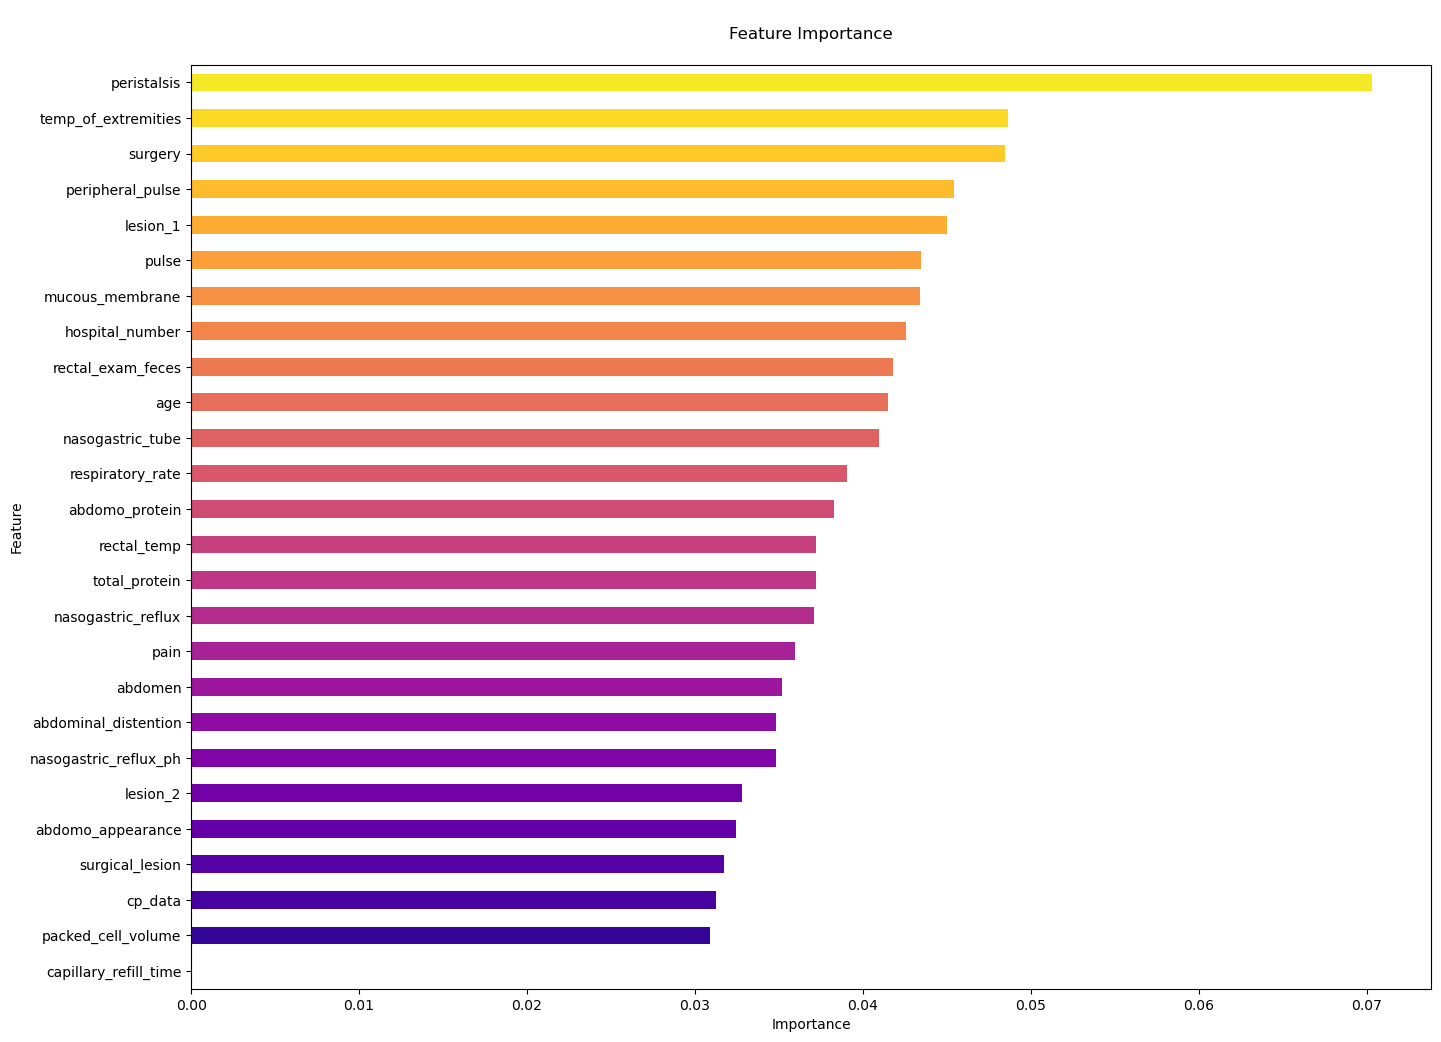

In [58]:
feature_importance = pd.DataFrame(
    data={
        "feature": df_train_org.columns[:-1],  # 这里用的是原始df
        "importance": models[0].feature_importances_,
    }
)

feature_importance = feature_importance.sort_values(by="importance", ascending=True)

feature_importance.plot(
    kind="barh",
    x="feature",
    y="importance",
    legend=False,
    color=sns.color_palette("plasma", n_colors=len(feature_importance)),
    figsize=(16, 12),
)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("\nFeature Importance\n", fontsize=12)
plt.show()

In [59]:
df_test_org.drop("lesion_3", axis=1, inplace=True)

X_test = pd.DataFrame(
    data=transformer.transform(df_test_org),
    columns=transformer.get_feature_names_out(),
    index=df_test_org.index,
)

In [61]:
predictions = []

for model in models:
    predictions.append(model.predict(X_test).ravel())
    
    
predictions = np.array(predictions)
print(predictions.shape)

final_predictions, _ = stats.mode(predictions, axis=0)

final_predictions.shape

(3, 824)


C:\Users\zzc\AppData\Local\Temp\ipykernel_21220\427828480.py:10: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_predictions, _ = stats.mode(predictions, axis=0)


(1, 824)

In [66]:
submission = pd.read_csv("./sample_submission.csv", index_col="id")

submission["outcome"] = target_encoder.inverse_transform(
    final_predictions.reshape(-1, 1)
).ravel()

submission.to_csv("submission.csv")